### Probablistic LSTM Modal

In [7]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
data = pd.read_csv("./data_saved/EURUSD_M1_2023.csv")

print(data.head(10))
print(data.describe())

# # Normalize data
# data_norm = data.copy()
# data_norm[['open', 'high', 'low', 'close']] = (data[['open', 'high', 'low', 'close']] - data[['open', 'high', 'low', 'close']].mean()) / data[['open', 'high', 'low', 'close']].std()

# data_norm.head(10)

             timestamp     open     high      low    close
0  2023-01-01 17:05:00  1.06973  1.06978  1.06970  1.06970
1  2023-01-01 17:06:00  1.06966  1.06966  1.06966  1.06966
2  2023-01-01 17:08:00  1.06970  1.06974  1.06970  1.06970
3  2023-01-01 17:10:00  1.06975  1.06980  1.06972  1.06972
4  2023-01-01 17:11:00  1.06972  1.06972  1.06972  1.06972
5  2023-01-01 17:12:00  1.06975  1.06980  1.06975  1.06975
6  2023-01-01 17:13:00  1.07066  1.07066  1.06917  1.06917
7  2023-01-01 17:14:00  1.06937  1.06937  1.06899  1.06899
8  2023-01-01 17:15:00  1.06788  1.06788  1.06788  1.06788
9  2023-01-01 17:16:00  1.06788  1.06788  1.06788  1.06788
                open           high            low          close
count  322637.000000  322637.000000  322637.000000  322637.000000
mean        1.080758       1.080831       1.080684       1.080684
std         0.016279       0.016277       0.016282       0.016282
min         1.044930       1.044980       1.044830       1.044830
25%         1.068360 

In [4]:
# Convert DataFrame to PyTorch tensor and move to GPU
data_tensor = torch.tensor(data[['close']].values, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension

data_tensor

tensor([[[1.0697],
         [1.0697],
         [1.0697],
         ...,
         [1.1037],
         [1.1037],
         [1.1036]]], device='cuda:0')

In [5]:
# Define LSTM model for probabilistic forecasting
class LSTMProbabilistic(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMProbabilistic, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Taking the output from the last time step
        out = self.softmax(out)  # Apply softmax activation to obtain probabilities
        return out


In [11]:

# Parameters
input_size = 1  # Number of features (only 'close' price)
hidden_size = 32  # Number of LSTM units
num_layers = 2  # Number of LSTM layers
output_size = 2  # Output size for binary classification (up or down)
sequence_length = 15  # Number of bars to consider for prediction

# Instantiate the model and move to GPU
model = LSTMProbabilistic(input_size, hidden_size, num_layers, output_size).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Prepare data with sequence length
data_sequences = []
for i in range(len(data) - sequence_length):
    data_sequences.append(data_tensor[:, i:i+sequence_length, :])
data_sequences_tensor = torch.cat(data_sequences, dim=0)

# Training loop
num_epochs = 1000
losses = []

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(data_sequences_tensor)
    
    # Prepare target labels (0 for down, 1 for up)
    target_labels = torch.zeros_like(data_sequences_tensor[:, -1, :])  # Initialize with zeros
    target_labels[data_sequences_tensor[:, -1, :] > data_sequences_tensor[:, -2, :]] = 1  # Set to 1 where price goes up
    
    # Flatten the target_labels tensor
    target_labels = target_labels.view(-1)
    
    # Flatten the outputs tensor
    outputs = outputs.view(-1, output_size)
    
    loss = criterion(outputs, target_labels.long())  # Cross entropy loss
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())  # Store the loss value for visualization
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [100/1000], Loss: 0.6909
Epoch [200/1000], Loss: 0.6909
Epoch [300/1000], Loss: 0.6909
Epoch [400/1000], Loss: 0.6908
Epoch [500/1000], Loss: 0.6908
Epoch [600/1000], Loss: 0.6908
Epoch [700/1000], Loss: 0.6908
Epoch [800/1000], Loss: 0.6908
Epoch [900/1000], Loss: 0.6908
Epoch [1000/1000], Loss: 0.6908


In [ ]:
import pandas as pd

# Training loop
num_epochs = 1000
losses = []
predictions = []

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(data_sequences_tensor)
    
    # Convert outputs to probabilities using softmax
    probabilities = torch.softmax(outputs, dim=2).squeeze().cpu().numpy()
    predicted_labels = torch.argmax(outputs, dim=2).squeeze().cpu().numpy()
    
    # Extract actual labels from the last element of each data sequence
    actual_labels = (data_sequences_tensor[:, -1, :] > data_sequences_tensor[:, -2, :]).squeeze().cpu().numpy().astype(int)
    
    # Combine predictions, probabilities, actual labels, and timestamps into a DataFrame
    for i in range(len(probabilities)):
        predictions.append({
            'Timestamp': data['timestamp'][i + sequence_length],
            'Predicted Label': predicted_labels[i],
            'Actual Label': actual_labels[i],
            'Probability (Down)': probabilities[i][0],
            'Probability (Up)': probabilities[i][1]
        })
    
    loss = criterion(outputs.view(-1, output_size), target_labels.long())  # Cross entropy loss
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())  # Store the loss value for visualization
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Create DataFrame from predictions
predictions_df = pd.DataFrame(predictions)

# Display the DataFrame
print(predictions_df)

In [17]:
import pandas as pd

# Evaluate the model on the test data
with torch.no_grad():
    predictions = []  # List to store predictions and probabilities

    for i in range(len(data) - sequence_length):
        data_sequence = data_tensor[:, i:i+sequence_length, :]
        output = model(data_sequence)  # Perform prediction
        probabilities = torch.softmax(output, dim=1).cpu().numpy().flatten()  # Calculate probabilities
        predicted_label = torch.argmax(output).item()  # Get predicted label (0 or 1)
        
        # Determine actual label based on the movement of the next bar
        actual_label = 0 if data_tensor[:, i+sequence_length, :] <= data_tensor[:, i+sequence_length-1, :] else 1
        
        # Store prediction result (1 for correct, 0 for incorrect)
        predictions.append({
            'Timestamp': data['timestamp'][i + sequence_length],
            'Predicted Label': predicted_label,
            'Actual Label': actual_label,
            'Probability (Down)': probabilities[0],  # Probability of price going down
            'Probability (Up)': probabilities[1]     # Probability of price going up
        })

# Create a DataFrame to display predictions
predictions_df = pd.DataFrame(predictions)

# Display the DataFrame
print(predictions_df)


                  Timestamp  Predicted Label  Actual Label  \
0       2023-01-01 17:48:00                0             0   
1       2023-01-01 17:49:00                0             1   
2       2023-01-01 17:50:00                0             0   
3       2023-01-01 17:51:00                0             0   
4       2023-01-01 17:52:00                0             1   
...                     ...              ...           ...   
322617  2023-12-29 16:54:00                0             1   
322618  2023-12-29 16:55:00                0             0   
322619  2023-12-29 16:56:00                0             0   
322620  2023-12-29 16:57:00                0             0   
322621  2023-12-29 16:58:00                0             0   

        Probability (Down)  Probability (Up)  
0                 0.538237          0.461763  
1                 0.538248          0.461752  
2                 0.538261          0.461739  
3                 0.538280          0.461720  
4                 0.

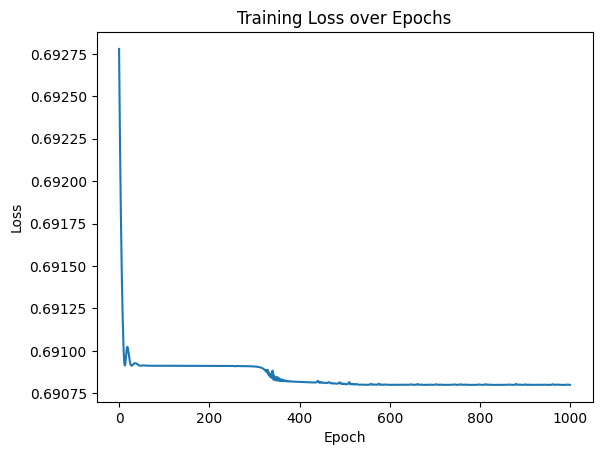

In [18]:
# Visualize the loss over epochs
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [ ]:
# Save PyTorch model
torch.save(model.state_dict(), './TrainedModals/lstm_probablistic_2023.pth')

# Save DataFrame to CSV
predictions_df.to_csv('./results/lstm_probablistic_2023.csv', index=False)


In [ ]:
import matplotlib.pyplot as plt

# Define the number of timestamps for each plot
timestamps_per_plot = 1000

# Evaluate the model on the test data
with torch.no_grad():
    for i in range(0, len(data) - sequence_length, timestamps_per_plot):
        # Extract the subset of data sequences for this plot
        data_sequences_subset = data_tensor[:, i:i+timestamps_per_plot+sequence_length, :]
        
        # Perform forward pass to get predictions
        outputs = model(data_sequences_subset)
        
        # Convert outputs to probabilities using softmax
        probabilities = torch.softmax(outputs, dim=2).squeeze().cpu().numpy()
        
        # Extract the timestamps and probabilities for the current subset
        subset_timestamps = data['timestamp'][i:i+timestamps_per_plot+sequence_length]
        subset_probabilities_down = probabilities[:, 0]
        subset_probabilities_up = probabilities[:, 1]
        
        # Plot the probabilities for the current subset
        plt.figure(figsize=(10, 6))
        plt.plot(subset_timestamps[sequence_length:], subset_probabilities_down, label='Probability of Going Down')
        plt.plot(subset_timestamps[sequence_length:], subset_probabilities_up, label='Probability of Going Up')
        plt.title('Probability of Price Movement for Subset of Data')
        plt.xlabel('Timestamp')
        plt.ylabel('Probability')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
